<a href="https://colab.research.google.com/github/irinadidid/baking-project/blob/main/baking_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dependencies 


In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import json
import platform
import time
import pathlib


In [2]:
print('Python version:', platform.python_version())
print('Tensorflow version:', tf.__version__)
print('Keras version:', tf.keras.__version__)

Python version: 3.7.12
Tensorflow version: 2.7.0
Keras version: 2.7.0


### Uploading the initial data

We will upload the data from Google drive, however the data scourse is https://www.kaggle.com/shuyangli94/food-com-recipes-and-user-interactions

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/data/RAW_recipes.csv'
data = pd.read_csv(path)

In [5]:
data.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8


In [6]:
data.shape

(231637, 12)

In [7]:
print(data.dtypes)

name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object


### Preprocessing the dataset

We will only need the recipes rows containing 'cake', 'cookie', 'bread' in their names. We will only use 'name', 'desription', 'ingredients', 'steps' columns.

In [8]:
#delete missing value function 
def MissingValues (data):
  if(data.isnull().values.any()): 
    columns = data.columns
    for column in columns: 
      data[data[column].isnull()] = ""
      data[data[column]=='NaN'] = ""
      data[pd.isna(data[column])] = ""
  return data


In [9]:
data = MissingValues(data)

In [10]:
#determine rows we need to remove 
remove1 = data.loc[data.name.map(lambda x: len(x)<4 )] #name of the recipe is too short 
remove2 = data.loc[data.ingredients.map(lambda x: len(x)<2 )] #recipe has less then 2 ingredients
remove3 = data.loc[data.steps.map(lambda x: len(x)<2 )] #recipe has less then 2 steps

len(remove1) + len(remove2) +len(remove3)

14950

In [11]:
data.drop(data[data.name.map(lambda x: len(x)<4 )].index, inplace=True)
data.drop(data[data.ingredients.map(lambda x: len(x)<2 )].index, inplace=True)
data.drop(data[data.steps.map(lambda x: len(x)<2 )].index, inplace=True)


In [12]:
data

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13
3,alouette potatoes,59389,45,68585,2003-04-14,"['60-minutes-or-less', 'time-to-make', 'course...","[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,['place potatoes in a large pot of lightly sal...,"this is a super easy, great tasting, make ahea...","['spreadable cheese with garlic and herbs', 'n...",11
4,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...,...,...,...,...,...,...
231632,zydeco soup,486161,60,227978,2012-08-29,"['ham', '60-minutes-or-less', 'time-to-make', ...","[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['heat oil in a 4-quart dutch oven', 'add cele...",this is a delicious soup that i originally fou...,"['celery', 'onion', 'green sweet pepper', 'gar...",22
231633,zydeco spice mix,493372,5,1500678,2013-01-09,"['15-minutes-or-less', 'time-to-make', 'course...","[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,['mix all ingredients together thoroughly'],this spice mix will make your taste buds dance!,"['paprika', 'salt', 'garlic powder', 'onion po...",13
231634,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...","[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",8
231635,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...","[188.0, 11.0, 57.0, 11.0, 7.0, 21.0, 9.0]",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10


In [13]:
# filter the data

data_filtered = data[(data['name'].str.contains("cake")) | 
     (data['name'].str.contains("cookie")) |
     (data['name'].str.contains("bread")) ][["name", "description", "ingredients", "n_ingredients", "steps", "n_steps", "minutes"]]

# create function to assign a recipe type

def f_type(row):
    if row['name'].find('cake') != -1:
      val = 'cake'
    elif row['name'].find('cookie') != -1:
      val = 'cookie'
    elif row['name'].find('bread') != -1:
      val = 'bread'
    else:
      val ='unknown'
    return val
    

data_filtered["r_type"] = data_filtered.apply(f_type, axis = 1)

print(data_filtered.shape)
data_filtered


(27863, 8)


,name,description,ingredients,n_ingredients,steps,n_steps,minutes,r_type
9,beat this banana bread,from ann hodgman's,"['sugar', 'unsalted butter', 'bananas', 'eggs'...",9,"['preheat oven to 350 degrees', 'butter two 9x...",12,70,bread
32,grilled ranch bread,buttery and,"['butter', 'dry ranch dressing mix', 'french b...",3,"['cream the butter with the dressing mix', 'sp...",4,13,bread
47,jeanne s style birthday cake,a bakery in winnipeg is famous for this specia...,"['shortening', 'icing sugar', 'vanilla', 'all-...",10,"['to prepare base , cut shortening into dry in...",25,230,cake
48,jiffy extra moist carrot cake,"this is a very tasty, moist, carrot cake. a ni...","['yellow cake mix', 'vanilla instant pudding m...",11,"['preheat oven to 350 degrees', 'mix together ...",8,50,cake
49,jiffy roasted corn and jalapeno cornbread,"this is a moist, easy, colorful and delicious ...","['whole kernel corn', 'onion', 'red bell peppe...",10,"['melt butter in a saut pan', 'add the corn , ...",10,35,bread
...,...,...,...,...,...,...,...,...
231618,zwetschgenkuchen plum cake,this is a classic german pastry and a deliciou...,"['margarine', 'all-purpose flour', 'sugar', 'b...",13,"['prepare pastry: cut margarine into flour , s...",11,60,cake
231621,zwieback toast teething cookies,a quintessential childhood food. this is a co...,"['sugar', 'active dry yeast', 'milk', 'butter'...",9,"['stir together 1 / 2 teaspoon of sugar , the ...",23,100,cookie
231624,zwiebelkuchen southwest german onion cake,this is a traditional late summer early fall s...,"['fresh yeast', 'milk', 'flour', 'butter', 'eg...",13,"['for the dough:', 'dissolve the yeast in the ...",10,75,cake
231635,cookies by design cookies on a stick,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",10,['place melted butter in a large mixing bowl a...,9,29,cookie


### Exploratory analysis (what do we know about cakes, cookies and bread?)

Let's see the distribution of the number of ingredients needed. This may show us the **complexity** of the recipe.

In [14]:
import plotly.figure_factory as ff
# let's see the distribution of the number of ingredients needed
cookie_n_ing = data_filtered.loc[data_filtered['r_type'] == 'cookie']["n_ingredients"]
cake_n_ing = data_filtered.loc[data_filtered['r_type'] == 'cake']["n_ingredients"]
bread_n_ing = data_filtered.loc[data_filtered['r_type'] == 'bread']["n_ingredients"]

hist_data = [cookie_n_ing.astype('float'), cake_n_ing.astype('float'), bread_n_ing.astype('float')]
group_labels = ['Cookie', 'Cake', 'Bread']
colors = ['rgb(239, 202, 8)', 'rgb(238, 66, 102)', 'rgb(0, 166, 166)']

fig = ff.create_distplot(hist_data, group_labels, bin_size = 1, colors = colors)
fig.show()
#hist_data_n_ing


Let's consider a number of steps in the recipe which is a good metric of the **recipe's difficulty** as well as **effort** to cook.

In [15]:
# let's see the distribution of the number of steps in recipe
cookie_n_steps = data_filtered.loc[data_filtered['r_type'] == 'cookie']["n_steps"]
cake_n_steps = data_filtered.loc[data_filtered['r_type'] == 'cake']["n_steps"]
bread_n_steps = data_filtered.loc[data_filtered['r_type'] == 'bread']["n_steps"]

hist_data = [cookie_n_steps.astype('float'), cake_n_steps.astype('float'), bread_n_steps.astype('float')]
group_labels = ['Cookie', 'Cake', 'Bread']
colors = ['rgb(239, 202, 8)', 'rgb(238, 66, 102)', 'rgb(0, 166, 166)']

fig = ff.create_distplot(hist_data, group_labels, bin_size = 1, colors = colors)
fig.show()

In [16]:
# calculate time to cook and remove outliers 
cookie_min = data_filtered.loc[data_filtered['r_type'] == 'cookie']["minutes"]
cake_min = data_filtered.loc[data_filtered['r_type'] == 'cake']["minutes"]
bread_min = data_filtered.loc[data_filtered['r_type'] == 'bread']["minutes"]

df1 = pd.DataFrame(cake_min[~((cake_min-cake_min.mean()).abs() > 1*cake_min.std())])
df2 = pd.DataFrame(cookie_min[~((cookie_min-cookie_min.mean()).abs() > 1*cookie_min.std())])
df3 = pd.DataFrame(bread_min[~((bread_min-bread_min.mean()).abs() > 1*bread_min.std())])


In [17]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Box(x=df1.minutes, name='Cake'))
fig.add_trace(go.Box(x=df2.minutes, name='Cookie'))
fig.add_trace(go.Box(x=df3.minutes, name='Bread'))

fig.show()

Here we notice that in both cases on average **cake** recipes seem to be more difficult to repeat as they require **more ingredients** and **more effort** i.e steps to folllow. 

For **cookies** we see **less variability** in number of ingredients and number of steps as well as time to cook. 

At the same time **bread** recipes are **very diverse**: from easy-to-follow 3 steps breads to very time consuming 145 steps recipe requiring 43 ingredients. On average **it takes longer to cook a bread** rather then cake or cookies.


### Text analysis (what makes a cookie that crunchy, cake that spongy, and bread that fluffy?)

**Next we will see what makes a cookie that crunchy, cake that spongy, and 
bread that fluffy**

In [18]:
# our ingredients contain some spechial charecters we won't need
from collections import Counter
#Counter(data_filtered['ingredients'].sum())
data_filtered['ingredients'] = data_filtered['ingredients'].str.replace('\"', '\'').replace('\[', '').replace('\"', '').replace('\]', '')
data_filtered['steps'] = data_filtered['steps'].str.replace('\"', '\'').replace('\[', '').replace('\"', '').replace('\]', '')

In [19]:
# calculate the most common ingredients for cakes, cookies and bread

cookie_ing = dict(Counter(data_filtered.loc[data_filtered['r_type'] == 'cookie']['ingredients'].apply(lambda x: x[2:-2].split('\', \'')).sum()).most_common())
cake_ing = dict(Counter(data_filtered.loc[data_filtered['r_type'] == 'cake']['ingredients'].apply(lambda x: x[2:-2].split('\', \'')).sum()).most_common())
bread_ing = dict(Counter(data_filtered.loc[data_filtered['r_type'] == 'bread']['ingredients'].apply(lambda x: x[2:-2].split('\', \'')).sum()).most_common())

In [20]:
# cookie most common ingredients
Counter(data_filtered.loc[data_filtered['r_type'] == 'cookie']['ingredients'].apply(lambda x: x[2:-2].split('\', \'')).sum()).most_common(15)

[('salt', 3666),
 ('butter', 3259),
 ('baking soda', 3242),
 ('sugar', 2599),
 ('flour', 2511),
 ('vanilla', 2282),
 ('eggs', 2193),
 ('brown sugar', 2139),
 ('egg', 2093),
 ('all-purpose flour', 1933),
 ('baking powder', 1881),
 ('vanilla extract', 1497),
 ('granulated sugar', 975),
 ('cinnamon', 859),
 ('unsalted butter', 730)]

In [21]:
# cake most common ingredients
Counter(data_filtered.loc[data_filtered['r_type'] == 'cake']['ingredients'].apply(lambda x: x[2:-2].split('\', \'')).sum()).most_common(15)

[('eggs', 8155),
 ('sugar', 6591),
 ('salt', 6291),
 ('butter', 5755),
 ('baking powder', 4906),
 ('baking soda', 3861),
 ('flour', 3723),
 ('milk', 3217),
 ('vanilla', 3203),
 ('all-purpose flour', 3005),
 ('vanilla extract', 2616),
 ('water', 2367),
 ('cream cheese', 2325),
 ('cinnamon', 2153),
 ('egg', 2120)]

In [22]:
# bread most common ingredients
Counter(data_filtered.loc[data_filtered['r_type'] == 'bread']['ingredients'].apply(lambda x: x[2:-2].split('\', \'')).sum()).most_common(15)

[('salt', 5367),
 ('sugar', 3499),
 ('butter', 2877),
 ('eggs', 2755),
 ('baking powder', 2083),
 ('baking soda', 2011),
 ('flour', 1913),
 ('water', 1821),
 ('milk', 1699),
 ('all-purpose flour', 1608),
 ('egg', 1403),
 ('cinnamon', 1055),
 ('whole wheat flour', 906),
 ('bread flour', 877),
 ('brown sugar', 848)]

In [23]:
# make a nice visualization 
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def makeImage(text):
  wc = WordCloud(background_color="white", max_words=50)
  wc.generate_from_frequencies(text)
  plt.imshow(wc, interpolation="bilinear")
  plt.axis("off")
  plt.show()


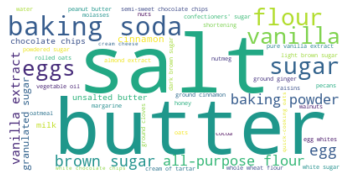

In [24]:
makeImage(cookie_ing)

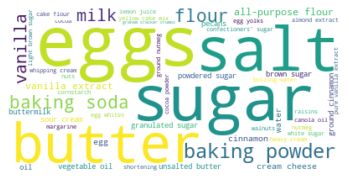

In [25]:
makeImage(cake_ing)

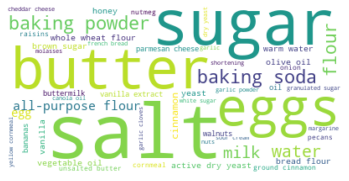

In [26]:
makeImage(bread_ing)

### Dataset to plain text 

In [27]:
data2text = data_filtered[["name", "description", "ingredients", "steps"]]

In [28]:
data2text.dtypes

name           object
description    object
ingredients    object
steps          object
dtype: object

In [29]:
data2text.reset_index(drop=True, inplace=True)

In [30]:
data2text = data2text.rename(columns={'name': 'title'})

In [31]:
data2text["ingredients"] = data2text["ingredients"].str.replace("\['", "").str.replace("\']", "")
data2text["steps"] = data2text["steps"].str.replace("\['", "").str.replace("\']", "")

In [32]:
data2text

,title,description,ingredients,steps
0,beat this banana bread,from ann hodgman's,"sugar', 'unsalted butter', 'bananas', 'eggs', ...","preheat oven to 350 degrees', 'butter two 9x5'..."
1,grilled ranch bread,buttery and,"butter', 'dry ranch dressing mix', 'french bread","cream the butter with the dressing mix', 'spre..."
2,jeanne s style birthday cake,a bakery in winnipeg is famous for this specia...,"shortening', 'icing sugar', 'vanilla', 'all-pu...","to prepare base , cut shortening into dry ingr..."
3,jiffy extra moist carrot cake,"this is a very tasty, moist, carrot cake. a ni...","yellow cake mix', 'vanilla instant pudding mix...","preheat oven to 350 degrees', 'mix together th..."
4,jiffy roasted corn and jalapeno cornbread,"this is a moist, easy, colorful and delicious ...","whole kernel corn', 'onion', 'red bell pepper'...","melt butter in a saut pan', 'add the corn , on..."
...,...,...,...,...
27858,zwetschgenkuchen plum cake,this is a classic german pastry and a deliciou...,"margarine', 'all-purpose flour', 'sugar', 'bak...","prepare pastry: cut margarine into flour , sug..."
27859,zwieback toast teething cookies,a quintessential childhood food. this is a co...,"sugar', 'active dry yeast', 'milk', 'butter', ...","stir together 1 / 2 teaspoon of sugar , the ye..."
27860,zwiebelkuchen southwest german onion cake,this is a traditional late summer early fall s...,"fresh yeast', 'milk', 'flour', 'butter', 'egg'...","for the dough:', 'dissolve the yeast in the lu..."
27861,cookies by design cookies on a stick,"i've heard of the 'cookies by design' company,...","butter', 'eagle brand condensed milk', 'light ...",place melted butter in a large mixing bowl and...


In [33]:
STOP_WORD_TITLE = '📌 TITLE\n\n'
STOP_WORD_DESCRIPTION = '\n👀 DESCRIPTION\n\n'
STOP_WORD_INGREDIENTS = '\n🍒 INGREDIENTS\n\n'
STOP_WORD_INSTRUCTIONS = '\n📝 INSTRUCTIONS\n\n'

In [34]:
def recipe_to_string(recipe):
  result = []
  for index, row in data2text.iterrows(): 
    title = row.title
    description = row.description
    ingredients = row.ingredients.split('\', \'')
    instructions = row.steps.split('\', \'')
    ingredients_string = ''
    for ingredient in ingredients:
            if ingredient:
                ingredients_string += f'• {ingredient}\n' 
    instructions_string = ''
    for instruction in instructions:
            if instruction:
                instructions_string += f'▪︎ {instruction}\n'
    result.append(f'{STOP_WORD_TITLE}{title}\n{STOP_WORD_DESCRIPTION}{description}\n{STOP_WORD_INGREDIENTS}{ingredients_string}{STOP_WORD_INSTRUCTIONS}{instructions_string}')
  return result

In [35]:
dataset_stringified = recipe_to_string(data2text) 

In [36]:
print('Stringified dataset size: ', len(dataset_stringified))

Stringified dataset size:  27863


In [37]:
for recipe_index, recipe_string in enumerate(dataset_stringified[:3]):
    print('Recipe #{}\n---------'.format(recipe_index + 1))
    print(recipe_string)
    print('\n')

Recipe #1
---------
📌 TITLE

beat this  banana bread

👀 DESCRIPTION

from ann hodgman's 

🍒 INGREDIENTS

• sugar
• unsalted butter
• bananas
• eggs
• fresh lemon juice
• orange rind
• cake flour
• baking soda
• salt

📝 INSTRUCTIONS

▪︎ preheat oven to 350 degrees
▪︎ butter two 9x5' loaf pans
▪︎ cream the sugar and the butter until light and whipped
▪︎ add the bananas , eggs , lemon juice , orange rind
▪︎ beat until blended uniformly
▪︎ be patient , and beat until the banana lumps are gone
▪︎ sift the dry ingredients together
▪︎ fold lightly and thoroughly into the banana mixture
▪︎ pour the batter into prepared loaf pans
▪︎ bake for 45 to 55 minutes , until the loaves are firm in the middle and the edges begin to pull away from the pans
▪︎ cool the loaves on racks for 30 minutes before removing from the pans
▪︎ freezes well



Recipe #2
---------
📌 TITLE

grilled  ranch bread

👀 DESCRIPTION

buttery and 

🍒 INGREDIENTS

• butter
• dry ranch dressing mix
• french bread

📝 INSTRUCTIONS



Let's see how many characters our recipes have

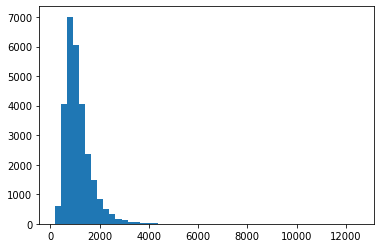

In [38]:
recipes_lengths = []
for recipe_text in dataset_stringified:
    recipes_lengths.append(len(recipe_text))

plt.hist(recipes_lengths, bins=50)
plt.show()

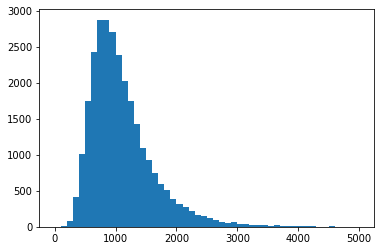

In [39]:
# For a closer examination lets consider recipes shorter then 5000 characters
plt.hist(recipes_lengths, range=(0, 5000), bins=50)
plt.show()

In [40]:
MAX_RECIPE_LENGTH = 2000

In [41]:
def filter_recipes_by_length(recipe_test):
    return len(recipe_test) <= MAX_RECIPE_LENGTH 

dataset_filtered = [recipe_text for recipe_text in dataset_stringified if filter_recipes_by_length(recipe_text)]

print('Dataset size BEFORE filtering: ', len(dataset_stringified))
print('Dataset size AFTER filtering: ', len(dataset_filtered))
print('Number of eliminated recipes: ', len(dataset_stringified) - len(dataset_filtered))

Dataset size BEFORE filtering:  27863
Dataset size AFTER filtering:  26062
Number of eliminated recipes:  1801


### Creating Vocabulary

In [42]:
STOP_SIGN = '*'

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    char_level=True,
    filters='',
    lower=False,
    split=''
)

# Stop word is not a part of recipes, but tokenizer must know about it as well.
tokenizer.fit_on_texts([STOP_SIGN])

tokenizer.fit_on_texts(dataset_filtered)

tokenizer.get_config()

{'char_level': True,
 'document_count': 26063,
 'filters': '',
 'index_docs': '{"1": 26062, "71": 332, "33": 26062, "10": 26061, "52": 26062, "28": 24713, "20": 26047, "23": 26062, "31": 26062, "56": 12988, "24": 26062, "55": 10980, "32": 26062, "22": 26013, "14": 26058, "34": 23968, "39": 26062, "15": 26054, "8": 26062, "27": 26062, "16": 26056, "43": 21056, "7": 26062, "42": 20638, "3": 26062, "41": 26062, "17": 26061, "29": 25690, "30": 26062, "50": 26062, "12": 26061, "9": 26062, "49": 26062, "25": 26062, "18": 26034, "26": 25905, "6": 26062, "11": 26062, "44": 21103, "51": 26062, "21": 26012, "47": 26062, "48": 26062, "53": 26062, "46": 13270, "58": 12158, "19": 26043, "61": 7536, "35": 26062, "5": 26062, "40": 26062, "54": 26062, "4": 26062, "13": 26059, "2": 26062, "45": 17710, "38": 20037, "60": 8227, "37": 20846, "63": 6519, "36": 22903, "57": 10546, "62": 5632, "65": 4413, "67": 3513, "59": 10272, "70": 2764, "78": 149, "68": 1803, "64": 5275, "66": 2121, "74": 620, "88": 51,

In [43]:
tokenizer_json = tokenizer.to_json()

In [44]:
print(tokenizer_json)

{"class_name": "Tokenizer", "config": {"num_words": null, "filters": "", "lower": false, "split": "", "char_level": true, "oov_token": null, "document_count": 26063, "word_counts": "{\"*\": 854, \"\\ud83d\\udccc\": 26062, \" \": 4351982, \"T\": 156372, \"I\": 182434, \"L\": 26062, \"E\": 104248, \"\\n\": 875409, \"b\": 407092, \"e\": 2188153, \"a\": 1562715, \"t\": 1507990, \"h\": 656263, \"i\": 1293026, \"s\": 1050269, \"n\": 1255003, \"r\": 1231768, \"d\": 732758, \"\\ud83d\\udc40\": 26062, \"D\": 52124, \"S\": 104248, \"C\": 52124, \"R\": 78186, \"P\": 26062, \"O\": 52124, \"N\": 130310, \"f\": 373111, \"o\": 1405310, \"m\": 498925, \"g\": 515216, \"'\": 27039, \"\\ud83c\\udf52\": 26062, \"G\": 26062, \"\\u2022\": 249672, \"u\": 662939, \"l\": 901468, \"j\": 24245, \"c\": 662778, \"k\": 297192, \"\\ud83d\\udcdd\": 26062, \"U\": 26062, \"\\u25aa\": 283108, \"\\ufe0e\": 283108, \"p\": 471700, \"v\": 169059, \"3\": 41026, \"5\": 43404, \"0\": 48546, \"w\": 303623, \"9\": 9143, \"x\": 8

In [45]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [46]:
VOCABULARY_SIZE = len(tokenizer.word_counts) + 1

print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

VOCABULARY_SIZE:  131


In [47]:
dataset_vectorized = tokenizer.texts_to_sequences(dataset_filtered)

print('Vectorized dataset size', len(dataset_vectorized))

Vectorized dataset size 26062


In [48]:
print(dataset_vectorized[0][:10], '...')

[47, 1, 30, 27, 30, 48, 32, 11, 11, 19] ...


In [49]:
def recipe_sequence_to_string(recipe_sequence):
    recipe_stringified = tokenizer.sequences_to_texts([recipe_sequence])[0]
    print(recipe_stringified)

recipe_sequence_to_string(dataset_vectorized[0])

📌   T I T L E 
 
 b e a t   t h i s     b a n a n a   b r e a d 
 
 👀   D E S C R I P T I O N 
 
 f r o m   a n n   h o d g m a n ' s   
 
 🍒   I N G R E D I E N T S 
 
 •   s u g a r 
 •   u n s a l t e d   b u t t e r 
 •   b a n a n a s 
 •   e g g s 
 •   f r e s h   l e m o n   j u i c e 
 •   o r a n g e   r i n d 
 •   c a k e   f l o u r 
 •   b a k i n g   s o d a 
 •   s a l t 
 
 📝   I N S T R U C T I O N S 
 
 ▪ ︎   p r e h e a t   o v e n   t o   3 5 0   d e g r e e s 
 ▪ ︎   b u t t e r   t w o   9 x 5 '   l o a f   p a n s 
 ▪ ︎   c r e a m   t h e   s u g a r   a n d   t h e   b u t t e r   u n t i l   l i g h t   a n d   w h i p p e d 
 ▪ ︎   a d d   t h e   b a n a n a s   ,   e g g s   ,   l e m o n   j u i c e   ,   o r a n g e   r i n d 
 ▪ ︎   b e a t   u n t i l   b l e n d e d   u n i f o r m l y 
 ▪ ︎   b e   p a t i e n t   ,   a n d   b e a t   u n t i l   t h e   b a n a n a   l u m p s   a r e   g o n e 
 ▪ ︎   s i f t   t h e   d r y   i n g r e d i e n t 

In [50]:
for recipe_index, recipe in enumerate(dataset_vectorized[:10]):
    print('Recipe #{} length: {}'.format(recipe_index + 1, len(recipe)))

Recipe #1 length: 816
Recipe #2 length: 332
Recipe #3 length: 1489
Recipe #4 length: 671
Recipe #5 length: 1005
Recipe #6 length: 1207
Recipe #7 length: 737
Recipe #8 length: 925
Recipe #9 length: 994
Recipe #10 length: 813


In [51]:
dataset_vectorized_padded_without_stops = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized,
    padding='post',
    truncating='post',
    # We use -1 here and +1 in the next step to make sure
    # that all recipes will have at least 1 stops sign at the end,
    # since each sequence will be shifted and truncated afterwards
    # (to generate X and Y sequences).
    maxlen=MAX_RECIPE_LENGTH-1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

dataset_vectorized_padded = tf.keras.preprocessing.sequence.pad_sequences(
    dataset_vectorized_padded_without_stops,
    padding='post',
    truncating='post',
    maxlen=MAX_RECIPE_LENGTH+1,
    value=tokenizer.texts_to_sequences([STOP_SIGN])[0]
)

for recipe_index, recipe in enumerate(dataset_vectorized_padded[:10]):
    print('Recipe #{} length: {}'.format(recipe_index, len(recipe)))

Recipe #0 length: 2001
Recipe #1 length: 2001
Recipe #2 length: 2001
Recipe #3 length: 2001
Recipe #4 length: 2001
Recipe #5 length: 2001
Recipe #6 length: 2001
Recipe #7 length: 2001
Recipe #8 length: 2001
Recipe #9 length: 2001


In [52]:
recipe_sequence_to_string(dataset_vectorized_padded[0])

📌   T I T L E 
 
 b e a t   t h i s     b a n a n a   b r e a d 
 
 👀   D E S C R I P T I O N 
 
 f r o m   a n n   h o d g m a n ' s   
 
 🍒   I N G R E D I E N T S 
 
 •   s u g a r 
 •   u n s a l t e d   b u t t e r 
 •   b a n a n a s 
 •   e g g s 
 •   f r e s h   l e m o n   j u i c e 
 •   o r a n g e   r i n d 
 •   c a k e   f l o u r 
 •   b a k i n g   s o d a 
 •   s a l t 
 
 📝   I N S T R U C T I O N S 
 
 ▪ ︎   p r e h e a t   o v e n   t o   3 5 0   d e g r e e s 
 ▪ ︎   b u t t e r   t w o   9 x 5 '   l o a f   p a n s 
 ▪ ︎   c r e a m   t h e   s u g a r   a n d   t h e   b u t t e r   u n t i l   l i g h t   a n d   w h i p p e d 
 ▪ ︎   a d d   t h e   b a n a n a s   ,   e g g s   ,   l e m o n   j u i c e   ,   o r a n g e   r i n d 
 ▪ ︎   b e a t   u n t i l   b l e n d e d   u n i f o r m l y 
 ▪ ︎   b e   p a t i e n t   ,   a n d   b e a t   u n t i l   t h e   b a n a n a   l u m p s   a r e   g o n e 
 ▪ ︎   s i f t   t h e   d r y   i n g r e d i e n t 

In [53]:
dataset = tf.data.Dataset.from_tensor_slices(dataset_vectorized_padded)

print(dataset)

<TensorSliceDataset shapes: (2001,), types: tf.int32>


In [54]:
for recipe in dataset.take(1):
    print('Raw recipe:\n', recipe.numpy(), '\n\n\n')
    print('Stringified recipe:\n')
    recipe_sequence_to_string(recipe.numpy())

Raw recipe:
 [47  1 30 ... 71 71 71] 



Stringified recipe:

📌   T I T L E 
 
 b e a t   t h i s     b a n a n a   b r e a d 
 
 👀   D E S C R I P T I O N 
 
 f r o m   a n n   h o d g m a n ' s   
 
 🍒   I N G R E D I E N T S 
 
 •   s u g a r 
 •   u n s a l t e d   b u t t e r 
 •   b a n a n a s 
 •   e g g s 
 •   f r e s h   l e m o n   j u i c e 
 •   o r a n g e   r i n d 
 •   c a k e   f l o u r 
 •   b a k i n g   s o d a 
 •   s a l t 
 
 📝   I N S T R U C T I O N S 
 
 ▪ ︎   p r e h e a t   o v e n   t o   3 5 0   d e g r e e s 
 ▪ ︎   b u t t e r   t w o   9 x 5 '   l o a f   p a n s 
 ▪ ︎   c r e a m   t h e   s u g a r   a n d   t h e   b u t t e r   u n t i l   l i g h t   a n d   w h i p p e d 
 ▪ ︎   a d d   t h e   b a n a n a s   ,   e g g s   ,   l e m o n   j u i c e   ,   o r a n g e   r i n d 
 ▪ ︎   b e a t   u n t i l   b l e n d e d   u n i f o r m l y 
 ▪ ︎   b e   p a t i e n t   ,   a n d   b e a t   u n t i l   t h e   b a n a n a   l u m p s   a r e   

### Split examples

In [55]:
def split_input_target(recipe):
    input_text = recipe[:-1]
    target_text = recipe[1:]
    
    return input_text, target_text

dataset_targeted = dataset.map(split_input_target)

print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [56]:
for input_example, target_example in dataset_targeted.take(1):
    print('Input sequence size:', repr(len(input_example.numpy())))
    print('Target sequence size:', repr(len(target_example.numpy())))
    print()
    
    input_stringified = tokenizer.sequences_to_texts([input_example.numpy()[:50]])[0]
    target_stringified = tokenizer.sequences_to_texts([target_example.numpy()[:50]])[0]
    
    print('Input:  ', repr(''.join(input_stringified)))
    print('Target: ', repr(''.join(target_stringified)))

Input sequence size: 2000
Target sequence size: 2000

Input:   '📌   T I T L E \n \n b e a t   t h i s     b a n a n a   b r e a d \n \n 👀   D E S C R I P T I O N \n \n f'
Target:  '  T I T L E \n \n b e a t   t h i s     b a n a n a   b r e a d \n \n 👀   D E S C R I P T I O N \n \n f r'


In [57]:
TOTAL_RECIPES_NUM = len(dataset_filtered)
print('TOTAL_RECIPES_NUM: ', TOTAL_RECIPES_NUM)
print('MAX_RECIPE_LENGTH: ', MAX_RECIPE_LENGTH)
print('VOCABULARY_SIZE: ', VOCABULARY_SIZE)

TOTAL_RECIPES_NUM:  26062
MAX_RECIPE_LENGTH:  2000
VOCABULARY_SIZE:  131


In [58]:
print(dataset_targeted)

<MapDataset shapes: ((2000,), (2000,)), types: (tf.int32, tf.int32)>


In [59]:
# Batch size
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1000
dataset_train = dataset_targeted.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).repeat()

print(dataset_train)


<RepeatDataset shapes: ((64, 2000), (64, 2000)), types: (tf.int32, tf.int32)>


In [60]:
for input_text, target_text in dataset_train.take(1):
    print('1st batch: input_text:', input_text)
    print()
    print('1st batch: target_text:', target_text)

1st batch: input_text: tf.Tensor(
[[47  1 30 ... 71 71 71]
 [47  1 30 ... 71 71 71]
 [47  1 30 ... 71 71 71]
 ...
 [47  1 30 ... 71 71 71]
 [47  1 30 ... 71 71 71]
 [47  1 30 ... 71 71 71]], shape=(64, 2000), dtype=int32)

1st batch: target_text: tf.Tensor(
[[ 1 30 27 ... 71 71 71]
 [ 1 30 27 ... 71 71 71]
 [ 1 30 27 ... 71 71 71]
 ...
 [ 1 30 27 ... 71 71 71]
 [ 1 30 27 ... 71 71 71]
 [ 1 30 27 ... 71 71 71]], shape=(64, 2000), dtype=int32)


### Build a model

In [61]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        batch_input_shape=[batch_size, None]
    ))

    model.add(tf.keras.layers.LSTM(
        units=rnn_units,
        return_sequences=True,
        stateful=True,
        recurrent_initializer=tf.keras.initializers.GlorotNormal()
    ))

    model.add(tf.keras.layers.Dense(vocab_size))
    
    return model

model = build_model(
  vocab_size=VOCABULARY_SIZE,
  embedding_dim=256,
  rnn_units=1024,
  batch_size=BATCH_SIZE
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           33536     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 131)           134275    
                                                                 
Total params: 5,414,787
Trainable params: 5,414,787
Non-trainable params: 0
_________________________________________________________________


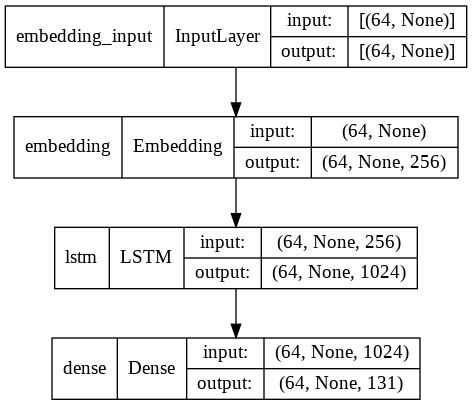

In [62]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file='model.png'
)

### Model before training 

In [63]:
for input_example_batch, target_example_batch in dataset_train.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 2000, 131) # (batch_size, sequence_length, vocab_size)


In [64]:
print('Prediction for the 1st letter of the batch 1st sequense:')
print(example_batch_predictions[0, 0])

Prediction for the 1st letter of the batch 1st sequense:
tf.Tensor(
[-2.6868926e-03 -3.7799513e-03 -8.5717620e-04 -2.6066421e-04
 -6.9159124e-04  1.3699981e-03  2.1130363e-03  1.7592280e-04
 -6.6667958e-04 -2.5000598e-03 -1.6930634e-03 -7.2398182e-04
 -2.0335324e-03  5.9416145e-04  3.6502350e-03 -3.7745894e-03
  1.0218988e-03  7.8346662e-04  7.8162802e-03 -1.7001786e-03
  4.2672562e-03  3.2041369e-03  4.9332058e-04 -4.2310357e-03
  4.9003004e-03 -2.4878804e-03 -2.0018031e-03  1.8323055e-03
  4.3372200e-03 -6.8856715e-03  5.5633299e-03  2.6581995e-03
  1.8808956e-03 -2.0862841e-03 -1.2289324e-03 -1.7484660e-03
 -1.9825550e-04 -6.0931053e-03  3.0368832e-03  1.8972341e-03
  6.8751378e-03  3.2619257e-03 -2.8812399e-03  1.5190032e-03
  2.4267149e-03  2.2952883e-03  2.3740162e-03 -3.2841051e-03
  7.7707443e-04 -2.8921582e-04  4.7723227e-03  2.3367703e-03
 -1.7177827e-04 -1.3140409e-03 -4.1681668e-03 -2.1073360e-03
  1.9467509e-03  9.5433253e-04 -5.0381925e-03 -1.2104354e-03
 -4.2574266e-03  

In [65]:
sampled_indices = tf.random.categorical(
    logits=example_batch_predictions[0],
    num_samples=1
)

sampled_indices = tf.squeeze(
    input=sampled_indices,
    axis=-1
).numpy()

sampled_indices.shape

(2000,)

In [66]:
print('Input:\n', repr(''.join(tokenizer.sequences_to_texts([input_example_batch[0].numpy()[:50]]))))
print()
print('Next char prediction:\n', repr(''.join(tokenizer.sequences_to_texts([sampled_indices[:50]]))))

Input:
 '📌   T I T L E \n \n a b b y   s   p e a c h e s     n   c r e a m   o v e n   p u f f e d   p a n c a'

Next char prediction:
 "📝 :   : v + 1 ù ú p + à 6 © ` 7 } T â _ P U ü “ ó ^ ¿ … \n @ : ” ™ ' ` – ö ä R j , – w — I E T ` ; c"


### Train the model

In [ ]:
# Create a checkpoints directory.
checkpoint_dir = 'tmp/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_{epoch}')
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True
)

In [ ]:
#!rm -d -r ./tmp

In [ ]:
def loss(labels, logits):
    entropy = tf.keras.losses.sparse_categorical_crossentropy(
      y_true=labels,
      y_pred=logits,
      from_logits=True
    )
    
    return entropy

example_batch_loss = loss(target_example_batch, example_batch_predictions)

print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss.shape:      ", example_batch_loss.shape)
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 2000, 131)  # (batch_size, sequence_length, vocab_size)
scalar_loss.shape:       (64, 2000)
scalar_loss:       4.879728


In [ ]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.002)

model.compile(
    optimizer=adam_optimizer,
    loss=loss
)

In [ ]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='loss',
    restore_best_weights=True,
    verbose=1
)

In [ ]:
EPOCHS = 200
INITIAL_EPOCH = 1
STEPS_PER_EPOCH = 25

print('EPOCHS:          ', EPOCHS)
print('INITIAL_EPOCH:   ', INITIAL_EPOCH)
print('STEPS_PER_EPOCH: ', STEPS_PER_EPOCH)

EPOCHS:           200
INITIAL_EPOCH:    1
STEPS_PER_EPOCH:  25


In [ ]:
history = model.fit(
    x=dataset_train,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    initial_epoch=INITIAL_EPOCH,
    callbacks=[
        checkpoint_callback,
        early_stopping_callback
    ]
)

# Saving the trained model to file (to be able to re-use it later).
model_name = 'recipe_generation_rnn_2.h5'
model.save(model_name, save_format='h5')

Epoch 2/200
25/25 [==============================] - 26s 952ms/step - loss: 2.6953
Epoch 3/200
25/25 [==============================] - 23s 940ms/step - loss: 1.6520
Epoch 4/200
25/25 [==============================] - 23s 940ms/step - loss: 1.4917
Epoch 5/200
25/25 [==============================] - 23s 939ms/step - loss: 1.3476
Epoch 6/200
25/25 [==============================] - 24s 941ms/step - loss: 1.1928
Epoch 7/200
25/25 [==============================] - 23s 940ms/step - loss: 1.0483
Epoch 8/200
25/25 [==============================] - 23s 940ms/step - loss: 1.0444
Epoch 9/200
25/25 [==============================] - 23s 940ms/step - loss: 0.9623
Epoch 10/200
25/25 [==============================] - 23s 940ms/step - loss: 0.9288
Epoch 11/200
25/25 [==============================] - 23s 940ms/step - loss: 0.8519
Epoch 12/200
25/25 [==============================] - 23s 940ms/step - loss: 0.7795
Epoch 13/200
25/25 [==============================] - 23s 940ms/step - loss: 0.7281


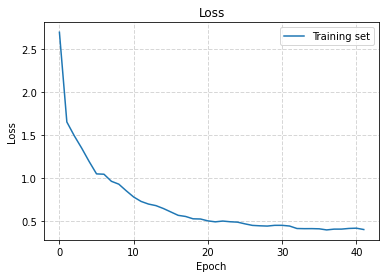

In [ ]:
def render_training_history(training_history):
    loss = training_history.history['loss']

    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)
    plt.show()

render_training_history(history)

In [ ]:
tf.train.latest_checkpoint(checkpoint_dir)

'tmp/checkpoints/ckpt_43'

### Use simplified model with saved weights 


In [67]:
simplified_batch_size = 1
vocab_size=VOCABULARY_SIZE
embedding_dim=256
rnn_units=1024

model_simplified = build_model(vocab_size, embedding_dim, rnn_units, simplified_batch_size)
model_simplified.load_weights('/content/drive/MyDrive/data/ckpt')
model_simplified.build(tf.TensorShape([simplified_batch_size, None]))

model_simplified.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (1, None, 256)            33536     
                                                                 
 lstm_1 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_1 (Dense)             (1, None, 131)            134275    
                                                                 
Total params: 5,414,787
Trainable params: 5,414,787
Non-trainable params: 0
_________________________________________________________________


In [68]:
def generate_text(start_string, num_generate, temperature, model = model_simplified):
    # Evaluation step (generating text using the learned model)
    
    padded_start_string = STOP_WORD_TITLE + start_string

    # Converting our start string to numbers (vectorizing).
    input_indices = np.array(tokenizer.texts_to_sequences([padded_start_string]))

    # Empty string to store our results.
    text_generated = []

    # Here batch size == 1.
    model.reset_states()
    for char_index in range(num_generate):
        predictions = model(input_indices)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # Using a categorical distribution to predict the character returned by the model.
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(
            predictions,
            num_samples=1
        )[-1, 0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state.
        input_indices = tf.expand_dims([predicted_id], 0)
        
        next_character = tokenizer.sequences_to_texts(input_indices.numpy())[0]

        text_generated.append(next_character)

    return (padded_start_string + ''.join(text_generated))

In [69]:
print(generate_text(start_string = 'chocolate', temperature= 0.4, num_generate= 1000))

📌 TITLE

chocolate cake

👀 DESCRIPTION

this is the dough on the topping with bread machine.

🍒 INGREDIENTS

• white sugar
• eggs
• milk
• vanilla extract
• all-purpose flour
• baking powder
• salt
• baking soda
• baking soda
• salt
• butter
• sugar
• vanilla extract
• baking powder
• baking soda
• salt
• sugar
• vanilla
• cream
• salt

📝 INSTRUCTIONS

▪︎ preheat oven to 350f
▪︎ butter a 9x5x3' pan
▪︎ blend self raising eggs , one at a time , beating well with the flour and salt
▪︎ stir in the chocolate chips and salt
▪︎ add the milk and vanilla
▪︎ stir in the butter , and mix well
▪︎ add the chocolate chips and remaining sugar
▪︎ add the eggs , one at a time , beating well after each addition
▪︎ pour into prepared pan
▪︎ bake at 350 for 12-12 minutes or until golden brown
▪︎ cool in pan for 10 minutes
▪︎ top with remaining cream cheese , then refrigerate for at least 2 hours or until the cake is set and the cake is set , about 25 minutes until the cake pan
▪︎ refrigerate for at least 

### Create Demo

In [70]:
!pip install gradio

     |████████████████████████████████| 865 kB 4.2 MB/s 
     |████████████████████████████████| 2.0 MB 52.1 MB/s 
     |████████████████████████████████| 210 kB 75.8 MB/s 
     |████████████████████████████████| 856 kB 60.2 MB/s 
     |████████████████████████████████| 3.6 MB 68.5 MB/s 
     |████████████████████████████████| 61 kB 510 kB/s 
  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4712 sha256=8d200139911f552bcbe51fb48624bccd2f423fb4f8848fc1ffc81d5af15c182a
  Stored in directory: /root/.cache/pip/wheels/13/e4/6c/e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for flask-cachebuster: filename=Flask_CacheBuster-1.0.0-py3-none-any.whl size=3373 sha256=9e3ac8a4a0864ba8d9dd21e3442601d1b0271f8b46af20f6aa87f00d0bd84833
  Stored in directory: /root/.cache/pip/wheels/28/c0/c4/44687421dab41455be93112bd1b0dee1f3c5a9aa27bee63708
Successfully built ffmpy flask-cachebuster


In [71]:
import gradio as gr


iface = gr.Interface(
  fn=generate_text, 
  inputs=["text", gr.inputs.Slider(0, 1000), gr.inputs.Slider(0, 1)],
  outputs=["text"])
iface.launch()




Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://10948.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<Flask 'gradio.networking'>,
 'http://127.0.0.1:7860/',
 'https://10948.gradio.app')